In [78]:
from pprint import pprint
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import pandas_ta as ta
import math
import backtrader as bt
import datetime
import random
import numpy as np

In [79]:


#https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/boletim-diario/dados-publicos-de-produtos-listados-e-de-balcao/
# Usamos apenas as colunas em que precisamos aplicar filtros
# O arquivo .csv não vem formatado em utf-8, então usamos o encoding = 'latin'
# Definimos o dtype da coluna CorpGovnLvlNm como string para não termos problema com a memória
df = pd.read_csv(
    'InstrumentsConsolidatedFile_20231204_1.csv',
    usecols= ['RptDt','TckrSymb', 'SgmtNm', 'SctyCtgyNm', 'TradgStartDt', 'CorpGovnLvlNm'],
    sep=';',
    encoding = 'latin',
    dtype={'CorpGovnLvlNm': 'str'})

# Filtramos SctyCtgyNm por ações e units (SHARES e UNIT)
# Filtramos SgmtNm por ações do mercado à vista (CASH)
# Filtramos os ativos cuja data de início da negociação seja anterior à data de publicação do arquivo .csv
# Filtramos as ações que não sejam negociadas no mercado de balcão
df = df[ ( (df['SctyCtgyNm'] == 'SHARES') | (df['SctyCtgyNm'] == 'UNIT') ) & (df['SgmtNm'] == 'CASH') & (df['RptDt'] >= df['TradgStartDt']) & (df['CorpGovnLvlNm'] != 'MERCADO DE BALCÃO') ]

df_listed_stocks = pd.DataFrame()
df_listed_stocks['Ticker'] = df['TckrSymb']

# Ativos de nome TAXA100, TAXA101, TAXA102 etc. não nos interessam
df_listed_stocks = df_listed_stocks[~df_listed_stocks['Ticker'].str.contains('TAXA')]

df_listed_stocks = df_listed_stocks['Ticker'].reset_index()
df_listed_stocks = df_listed_stocks.drop(columns=['index'])

df_listed_stocks.to_csv('b3_stocks.csv', index=False)

print(df_listed_stocks['Ticker'])

0      AALR3
1      ABCB4
2      ABEV3
3      AERI3
4      AESB3
       ...  
549    WLMM4
550    YBRA3
551    YBRA4
552    YDUQ3
553    ZAMP3
Name: Ticker, Length: 554, dtype: object


In [80]:
stock_list = [stock[0] +'.SA' for stock in df_listed_stocks.values]

pprint(stock_list[:10])

['AALR3.SA',
 'ABCB4.SA',
 'ABEV3.SA',
 'AERI3.SA',
 'AESB3.SA',
 'AESO3.SA',
 'AFLT3.SA',
 'AGRO3.SA',
 'AGXY3.SA',
 'AHEB3.SA']


In [81]:
len(df_listed_stocks['Ticker'].unique())

554

In [82]:
df.columns

Index(['RptDt', 'TckrSymb', 'SgmtNm', 'SctyCtgyNm', 'TradgStartDt',
       'CorpGovnLvlNm'],
      dtype='object')

In [83]:
start_date = '2022-01-01'
end_date = '2023-01-01'
df_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ticker']
stocks_df = pd.DataFrame(columns=[df_cols])
stocks_df

,Open,High,Low,Close,Adj Close,Volume,ticker


In [84]:
for stock in tqdm(stock_list[:], desc="Processing"):
    print(stock)
    temp_df = yf.download(stock, start=start_date, end=end_date)
    if len(temp_df) != 0:
        temp_df = temp_df.assign(ticker = stock)
        stocks_df = pd.concat([stocks_df[df_cols], temp_df[df_cols]])

Processing:   0%|          | 0/554 [00:00<?, ?it/s]

AALR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   0%|          | 1/554 [00:00<07:17,  1.26it/s]


ABCB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   0%|          | 2/554 [00:01<04:33,  2.02it/s]


ABEV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|          | 3/554 [00:01<03:40,  2.49it/s]


AERI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|          | 4/554 [00:01<03:11,  2.87it/s]


AESB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|          | 5/554 [00:01<03:00,  3.03it/s]


AESO3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AESO3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   1%|          | 6/554 [00:03<05:30,  1.66it/s]


AFLT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|▏         | 7/554 [00:03<04:34,  2.00it/s]


AGRO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|▏         | 8/554 [00:03<03:58,  2.29it/s]


AGXY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 9/554 [00:03<03:30,  2.58it/s]


AHEB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 10/554 [00:04<03:11,  2.84it/s]


AHEB5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 11/554 [00:04<02:57,  3.07it/s]


AHEB6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 12/554 [00:04<02:49,  3.19it/s]


ALLD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 13/554 [00:05<02:43,  3.31it/s]


ALOS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALOS3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1641006000, endDate = 1672542000")
Processing:   3%|▎         | 14/554 [00:05<03:52,  2.32it/s]


ALOS99.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALOS99.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   3%|▎         | 15/554 [00:06<04:40,  1.92it/s]


ALPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 16/554 [00:06<04:02,  2.22it/s]


ALPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 17/554 [00:07<03:35,  2.49it/s]


ALPK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 18/554 [00:07<03:16,  2.73it/s]


ALUP11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 19/554 [00:07<03:02,  2.94it/s]


ALUP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▎         | 20/554 [00:07<02:54,  3.07it/s]


ALUP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 21/554 [00:08<02:48,  3.17it/s]


AMAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 22/554 [00:08<02:41,  3.29it/s]


AMBP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 23/554 [00:08<02:38,  3.35it/s]


AMER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 24/554 [00:09<02:38,  3.35it/s]


ANIM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▍         | 25/554 [00:09<02:34,  3.43it/s]


APER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▍         | 26/554 [00:09<02:35,  3.40it/s]


APTI3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['APTI3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   5%|▍         | 27/554 [00:10<04:16,  2.06it/s]


APTI4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['APTI4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   5%|▌         | 28/554 [00:11<05:02,  1.74it/s]


ARML3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▌         | 29/554 [00:11<04:51,  1.80it/s]


ARZZ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▌         | 30/554 [00:12<04:12,  2.08it/s]


ASAI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 31/554 [00:12<03:44,  2.33it/s]


ATMP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 32/554 [00:12<03:20,  2.61it/s]


ATOM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 33/554 [00:13<03:03,  2.84it/s]


AURE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 34/554 [00:13<02:51,  3.04it/s]


AVLL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▋         | 35/554 [00:13<02:42,  3.19it/s]


AZEV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▋         | 36/554 [00:13<02:37,  3.30it/s]


AZEV4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 37/554 [00:14<02:32,  3.39it/s]


AZUL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 38/554 [00:14<02:27,  3.49it/s]


B3SA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 39/554 [00:14<02:28,  3.46it/s]


BAHI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 40/554 [00:15<03:00,  2.85it/s]


BALM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 41/554 [00:15<02:51,  2.99it/s]


BALM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 42/554 [00:15<02:44,  3.11it/s]


BAUH3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 43/554 [00:16<02:40,  3.19it/s]


BAUH4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 44/554 [00:16<02:34,  3.31it/s]


BAZA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 45/554 [00:16<02:33,  3.33it/s]


BBAS11.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BBAS11.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:   8%|▊         | 46/554 [00:16<02:29,  3.41it/s]


BBAS12.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BBAS12.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:   8%|▊         | 47/554 [00:17<02:23,  3.52it/s]


BBAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▊         | 48/554 [00:17<02:29,  3.40it/s]


BBDC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▉         | 49/554 [00:17<02:30,  3.35it/s]


BBDC4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▉         | 50/554 [00:18<02:32,  3.30it/s]


BBML3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BBML3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   9%|▉         | 51/554 [00:18<03:35,  2.34it/s]


BBSE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▉         | 52/554 [00:19<03:13,  2.60it/s]


BDLL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|▉         | 53/554 [00:19<02:56,  2.84it/s]


BDLL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|▉         | 54/554 [00:19<02:46,  3.01it/s]


BEEF3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|▉         | 55/554 [00:20<02:39,  3.12it/s]


BEES3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|█         | 56/554 [00:20<02:36,  3.18it/s]


BEES4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|█         | 57/554 [00:20<02:32,  3.26it/s]


BETP3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BETP3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  10%|█         | 58/554 [00:21<03:33,  2.32it/s]


BGIP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 59/554 [00:21<03:12,  2.57it/s]


BGIP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 60/554 [00:21<03:00,  2.74it/s]


BHIA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 61/554 [00:22<02:49,  2.90it/s]


BIOM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 62/554 [00:22<02:39,  3.08it/s]


BLAU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█▏        | 63/554 [00:22<02:32,  3.22it/s]


BMEB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 64/554 [00:23<02:31,  3.24it/s]


BMEB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 65/554 [00:23<02:27,  3.32it/s]


BMGB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 66/554 [00:23<02:23,  3.40it/s]


BMIN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 67/554 [00:23<02:22,  3.41it/s]


BMIN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 68/554 [00:24<02:20,  3.46it/s]


BMKS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 69/554 [00:24<02:20,  3.44it/s]


BMOB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 70/554 [00:24<02:18,  3.48it/s]


BNBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 71/554 [00:25<02:17,  3.51it/s]


BOBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 72/554 [00:25<02:15,  3.56it/s]


BOBR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 73/554 [00:25<02:12,  3.63it/s]


BPAC11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 74/554 [00:25<02:15,  3.53it/s]


BPAC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▎        | 75/554 [00:26<02:17,  3.49it/s]


BPAC5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▎        | 76/554 [00:26<02:15,  3.52it/s]


BPAN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▍        | 77/554 [00:26<02:16,  3.50it/s]


BPAR3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BPAR3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  14%|█▍        | 78/554 [00:27<03:18,  2.39it/s]


BRAP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▍        | 79/554 [00:27<03:08,  2.53it/s]


BRAP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▍        | 80/554 [00:28<02:55,  2.71it/s]


BRBI11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▍        | 81/554 [00:28<02:43,  2.89it/s]


BRFS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▍        | 82/554 [00:28<02:34,  3.05it/s]


BRGE11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▍        | 83/554 [00:28<02:28,  3.16it/s]


BRGE12.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▌        | 84/554 [00:29<02:29,  3.14it/s]


BRGE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▌        | 85/554 [00:29<02:26,  3.19it/s]


BRGE5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 86/554 [00:29<02:23,  3.27it/s]


BRGE6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 87/554 [00:30<02:19,  3.34it/s]


BRGE7.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 88/554 [00:30<02:16,  3.41it/s]


BRGE8.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 89/554 [00:30<02:14,  3.45it/s]


BRIT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 90/554 [00:31<02:12,  3.49it/s]


BRIV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▋        | 91/554 [00:31<02:12,  3.51it/s]


BRIV4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 92/554 [00:31<02:43,  2.83it/s]


BRKM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 93/554 [00:32<02:33,  3.01it/s]


BRKM5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 94/554 [00:32<02:29,  3.08it/s]


BRKM6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 95/554 [00:32<02:23,  3.20it/s]


BRQB3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BRQB3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  17%|█▋        | 96/554 [00:32<02:16,  3.37it/s]


BRSR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 97/554 [00:33<02:16,  3.34it/s]


BRSR5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 98/554 [00:33<02:15,  3.37it/s]


BRSR6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 99/554 [00:33<02:14,  3.39it/s]


BSLI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 100/554 [00:34<02:14,  3.39it/s]


BSLI4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 101/554 [00:34<02:12,  3.42it/s]


CABI3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CABI3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  18%|█▊        | 102/554 [00:35<03:15,  2.31it/s]


CALI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▊        | 103/554 [00:35<02:55,  2.57it/s]


CAMB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 104/554 [00:35<02:43,  2.76it/s]


CAML3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 105/554 [00:36<02:33,  2.92it/s]


CASH3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 106/554 [00:36<02:51,  2.61it/s]


CASN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 107/554 [00:36<02:39,  2.80it/s]


CASN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 108/554 [00:37<02:28,  3.00it/s]


CATA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CATA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  20%|█▉        | 109/554 [00:37<03:20,  2.22it/s]


CATA4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CATA4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  20%|█▉        | 110/554 [00:38<03:59,  1.85it/s]


CBAV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  20%|██        | 111/554 [00:38<03:23,  2.18it/s]


CBEE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  20%|██        | 112/554 [00:39<03:01,  2.44it/s]


CCRO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  20%|██        | 113/554 [00:39<02:44,  2.68it/s]


CEAB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 114/554 [00:39<02:30,  2.93it/s]


CEBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 115/554 [00:40<02:23,  3.06it/s]


CEBR5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 116/554 [00:40<02:18,  3.16it/s]


CEBR6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 117/554 [00:40<02:16,  3.21it/s]


CEDO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██▏       | 118/554 [00:40<02:10,  3.34it/s]


CEDO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██▏       | 119/554 [00:41<02:06,  3.44it/s]


CEEB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 120/554 [00:41<02:08,  3.39it/s]


CEEB5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 121/554 [00:41<02:07,  3.38it/s]


CEEB6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CEEB6.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  22%|██▏       | 122/554 [00:42<03:05,  2.32it/s]


CEED3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 123/554 [00:42<02:46,  2.58it/s]


CEED4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 124/554 [00:43<02:31,  2.84it/s]


CEGR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 125/554 [00:43<02:23,  2.99it/s]


CGAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 126/554 [00:43<02:16,  3.14it/s]


CGAS5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 127/554 [00:43<02:12,  3.23it/s]


CGEE3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CGEE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  23%|██▎       | 128/554 [00:44<03:10,  2.24it/s]


CGEE4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CGEE4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  23%|██▎       | 129/554 [00:45<03:45,  1.88it/s]


CGRA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 130/554 [00:45<03:14,  2.18it/s]


CGRA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▎       | 131/554 [00:45<02:52,  2.45it/s]


CIEL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 132/554 [00:46<02:38,  2.66it/s]


CLSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 133/554 [00:46<02:25,  2.90it/s]


CLSC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 134/554 [00:46<02:17,  3.04it/s]


CLSC4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 135/554 [00:47<02:11,  3.18it/s]


CMIG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▍       | 136/554 [00:47<02:10,  3.21it/s]


CMIG4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▍       | 137/554 [00:47<02:07,  3.28it/s]


CMIN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▍       | 138/554 [00:48<02:03,  3.36it/s]


CMSA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CMSA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  25%|██▌       | 139/554 [00:48<03:01,  2.29it/s]


CMSA4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CMSA4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  25%|██▌       | 140/554 [00:49<03:40,  1.88it/s]


COCE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▌       | 141/554 [00:49<03:11,  2.16it/s]


COCE5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▌       | 142/554 [00:50<02:52,  2.39it/s]


COCE6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▌       | 143/554 [00:50<03:05,  2.21it/s]


COGN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▌       | 144/554 [00:50<02:46,  2.47it/s]


COMR3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['COMR3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  26%|██▌       | 145/554 [00:51<03:25,  1.99it/s]


CORR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▋       | 146/554 [00:52<03:05,  2.19it/s]


CORR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 147/554 [00:52<02:44,  2.47it/s]


CPFE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 148/554 [00:52<02:31,  2.68it/s]


CPLE11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 149/554 [00:52<02:20,  2.88it/s]


CPLE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 150/554 [00:53<02:14,  3.00it/s]


CPLE5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 151/554 [00:53<02:08,  3.13it/s]


CPLE6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 152/554 [00:53<02:07,  3.16it/s]


CRFB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 153/554 [00:54<02:02,  3.26it/s]


CRIV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 154/554 [00:54<02:01,  3.30it/s]


CRIV4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 155/554 [00:54<01:58,  3.36it/s]


CRPG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 156/554 [00:54<01:57,  3.37it/s]


CRPG5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 157/554 [00:55<01:58,  3.35it/s]


CRPG6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▊       | 158/554 [00:55<01:58,  3.33it/s]


CRTE3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CRTE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  29%|██▊       | 159/554 [00:56<02:50,  2.31it/s]


CRTE5.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CRTE5.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  29%|██▉       | 160/554 [00:57<03:51,  1.70it/s]


CSAB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▉       | 161/554 [00:57<03:17,  1.99it/s]


CSAB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▉       | 162/554 [00:57<02:52,  2.28it/s]


CSAN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▉       | 163/554 [00:58<02:34,  2.53it/s]


CSED3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|██▉       | 164/554 [00:58<02:21,  2.75it/s]


CSMG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|██▉       | 165/554 [00:58<02:13,  2.91it/s]


CSNA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|██▉       | 166/554 [00:59<02:11,  2.95it/s]


CSRN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|███       | 167/554 [00:59<02:06,  3.05it/s]


CSRN5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|███       | 168/554 [00:59<02:03,  3.13it/s]


CSRN6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███       | 169/554 [00:59<02:00,  3.21it/s]


CSUD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███       | 170/554 [01:00<01:56,  3.30it/s]


CTBA11B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CTBA11B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  31%|███       | 171/554 [01:00<02:45,  2.32it/s]


CTCA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CTCA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  31%|███       | 172/554 [01:01<03:19,  1.92it/s]


CTKA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███       | 173/554 [01:01<02:50,  2.24it/s]


CTKA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███▏      | 174/554 [01:02<02:30,  2.53it/s]


CTNM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 175/554 [01:02<02:16,  2.78it/s]


CTNM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 176/554 [01:02<02:07,  2.96it/s]


CTSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 177/554 [01:03<02:02,  3.09it/s]


CTSA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 178/554 [01:03<01:58,  3.17it/s]


CURY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 179/554 [01:03<01:57,  3.20it/s]


CVCB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 180/554 [01:04<01:53,  3.29it/s]


CXSE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 181/554 [01:04<01:50,  3.36it/s]


CYRE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 182/554 [01:04<01:51,  3.33it/s]


DASA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 183/554 [01:04<01:49,  3.39it/s]


DESK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 184/554 [01:05<01:46,  3.48it/s]


DEXP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 185/554 [01:05<01:46,  3.48it/s]


DEXP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▎      | 186/554 [01:05<01:48,  3.40it/s]


DIRR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 187/554 [01:06<01:47,  3.41it/s]


DMFN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 188/554 [01:06<01:45,  3.46it/s]


DMVF3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 189/554 [01:06<01:43,  3.53it/s]


DOHL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 190/554 [01:06<01:43,  3.52it/s]


DOHL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 191/554 [01:07<01:44,  3.48it/s]


DOTZ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▍      | 192/554 [01:07<01:42,  3.54it/s]


DTCY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▍      | 193/554 [01:07<01:41,  3.57it/s]


DTCY4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DTCY4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  35%|███▌      | 194/554 [01:08<02:29,  2.41it/s]


DXCO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▌      | 195/554 [01:08<02:16,  2.63it/s]


EALT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▌      | 196/554 [01:09<02:07,  2.81it/s]


EALT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 197/554 [01:09<01:59,  2.99it/s]


ECOR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 198/554 [01:09<01:54,  3.10it/s]


EGIE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 199/554 [01:09<01:51,  3.19it/s]


EKTR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 200/554 [01:10<01:48,  3.25it/s]


EKTR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▋      | 201/554 [01:10<01:48,  3.27it/s]


ELET3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▋      | 202/554 [01:10<01:46,  3.30it/s]


ELET5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 203/554 [01:11<01:46,  3.28it/s]


ELET6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 204/554 [01:11<01:46,  3.28it/s]


ELMD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 205/554 [01:11<01:43,  3.38it/s]


EMAE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 206/554 [01:11<01:41,  3.44it/s]


EMAE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 207/554 [01:12<01:42,  3.37it/s]


EMBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 208/554 [01:12<01:41,  3.40it/s]


ENAT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 209/554 [01:12<01:42,  3.38it/s]


ENEV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 210/554 [01:13<01:39,  3.47it/s]


ENGI11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 211/554 [01:13<01:39,  3.46it/s]


ENGI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 212/554 [01:13<01:38,  3.46it/s]


ENGI4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 213/554 [01:13<01:37,  3.49it/s]


ENJU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▊      | 214/554 [01:14<01:35,  3.56it/s]


ENMT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 215/554 [01:14<01:35,  3.53it/s]


ENMT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 216/554 [01:14<01:36,  3.51it/s]


EPAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 217/554 [01:15<01:36,  3.51it/s]


EQMA3B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 218/554 [01:15<01:35,  3.52it/s]


EQMA5B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EQMA5B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  40%|███▉      | 219/554 [01:16<02:19,  2.40it/s]


EQMA6B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EQMA6B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  40%|███▉      | 220/554 [01:16<02:50,  1.96it/s]


EQPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|███▉      | 221/554 [01:17<02:28,  2.25it/s]


EQPA5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|████      | 222/554 [01:17<02:11,  2.53it/s]


EQPA6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|████      | 223/554 [01:17<01:59,  2.76it/s]


EQPA7.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|████      | 224/554 [01:18<01:53,  2.91it/s]


EQTL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 225/554 [01:18<01:50,  2.99it/s]


ESPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 226/554 [01:18<01:44,  3.14it/s]


ESTR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 227/554 [01:18<01:39,  3.28it/s]


ESTR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 228/554 [01:19<01:36,  3.37it/s]


ETER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████▏     | 229/554 [01:19<01:35,  3.41it/s]


EUCA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 230/554 [01:19<01:34,  3.43it/s]


EUCA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 231/554 [01:20<01:35,  3.39it/s]


EUFA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EUFA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  42%|████▏     | 232/554 [01:20<02:18,  2.33it/s]


EVEN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 233/554 [01:21<02:07,  2.52it/s]


EZTC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 234/554 [01:21<01:57,  2.73it/s]


FESA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 235/554 [01:21<01:51,  2.87it/s]


FESA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 236/554 [01:22<01:46,  3.00it/s]


FHER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 237/554 [01:22<01:41,  3.12it/s]


FIEI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 238/554 [01:22<01:37,  3.25it/s]


FIGE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 239/554 [01:22<01:35,  3.31it/s]


FIGE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 240/554 [01:23<01:33,  3.35it/s]


FIQE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▎     | 241/554 [01:23<01:32,  3.37it/s]


FLRY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▎     | 242/554 [01:23<01:31,  3.40it/s]


FRAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▍     | 243/554 [01:24<01:38,  3.16it/s]


FRIO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▍     | 244/554 [01:24<01:34,  3.28it/s]


FRRN3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FRRN3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  44%|████▍     | 245/554 [01:25<02:13,  2.31it/s]


FRRN5B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FRRN5B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  44%|████▍     | 246/554 [01:25<02:40,  1.92it/s]


FRRN6B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FRRN6B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  45%|████▍     | 247/554 [01:26<02:59,  1.71it/s]


FRTA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▍     | 248/554 [01:26<02:30,  2.04it/s]


GEPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▍     | 249/554 [01:27<02:11,  2.32it/s]


GEPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▌     | 250/554 [01:27<01:57,  2.58it/s]


GFSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▌     | 251/554 [01:27<01:52,  2.70it/s]


GGBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▌     | 252/554 [01:28<01:45,  2.86it/s]


GGBR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 253/554 [01:28<01:42,  2.94it/s]


GGPS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 254/554 [01:28<01:37,  3.08it/s]


GMAT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 255/554 [01:28<01:35,  3.12it/s]


GOAU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 256/554 [01:29<01:35,  3.12it/s]


GOAU4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▋     | 257/554 [01:29<01:38,  3.03it/s]


GOLL3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GOLL3.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  47%|████▋     | 258/554 [01:29<01:32,  3.19it/s]


GOLL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 259/554 [01:30<01:30,  3.26it/s]


GPAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 260/554 [01:30<01:28,  3.32it/s]


GRAO3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GRAO3.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  47%|████▋     | 261/554 [01:30<01:25,  3.41it/s]


GRND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 262/554 [01:31<01:44,  2.81it/s]


GSHP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 263/554 [01:31<01:36,  3.03it/s]


GUAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 264/554 [01:31<01:33,  3.11it/s]


HAGA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 265/554 [01:32<01:29,  3.22it/s]


HAGA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 266/554 [01:32<01:26,  3.33it/s]


HAPV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 267/554 [01:32<01:27,  3.30it/s]


HAPV99.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HAPV99.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  48%|████▊     | 268/554 [01:33<02:04,  2.29it/s]


HBOR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▊     | 269/554 [01:33<01:52,  2.53it/s]


HBRE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▊     | 270/554 [01:34<01:42,  2.78it/s]


HBSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▉     | 271/554 [01:34<01:35,  2.98it/s]


HBTS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HBTS3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  49%|████▉     | 272/554 [01:34<01:29,  3.15it/s]


HBTS5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▉     | 273/554 [01:34<01:26,  3.23it/s]


HBTS6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HBTS6.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  49%|████▉     | 274/554 [01:35<01:22,  3.38it/s]


HETA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|████▉     | 275/554 [01:35<01:20,  3.49it/s]


HETA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|████▉     | 276/554 [01:35<01:18,  3.52it/s]


HMOB3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HMOB3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  50%|█████     | 277/554 [01:36<01:56,  2.39it/s]


HOOT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|█████     | 278/554 [01:36<01:43,  2.66it/s]


HOOT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|█████     | 279/554 [01:36<01:35,  2.89it/s]


HYPE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████     | 280/554 [01:37<01:58,  2.31it/s]


IFCM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████     | 281/554 [01:37<01:45,  2.58it/s]


IGSN3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IGSN3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  51%|█████     | 282/554 [01:38<01:35,  2.85it/s]


IGTI11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████     | 283/554 [01:38<01:31,  2.95it/s]


IGTI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████▏    | 284/554 [01:38<01:28,  3.04it/s]


IGTI4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IGTI4.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1641006000, endDate = 1672542000")
Processing:  51%|█████▏    | 285/554 [01:39<02:01,  2.22it/s]


INEP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 286/554 [01:39<01:47,  2.50it/s]


INEP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 287/554 [01:40<01:37,  2.73it/s]


INNT3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['INNT3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  52%|█████▏    | 288/554 [01:40<02:07,  2.09it/s]


INTB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 289/554 [01:41<01:50,  2.39it/s]


IRBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 290/554 [01:41<01:38,  2.68it/s]


ITSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 291/554 [01:41<01:33,  2.80it/s]


ITSA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 292/554 [01:41<01:29,  2.94it/s]


ITUB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 293/554 [01:42<01:25,  3.05it/s]


ITUB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 294/554 [01:42<01:22,  3.15it/s]


IVPR3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IVPR3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  53%|█████▎    | 295/554 [01:43<01:57,  2.21it/s]


IVPR4B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IVPR4B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  53%|█████▎    | 296/554 [01:44<02:21,  1.83it/s]


JALL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▎    | 297/554 [01:44<02:00,  2.13it/s]


JBSS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 298/554 [01:44<01:51,  2.30it/s]


JFEN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 299/554 [01:45<01:39,  2.56it/s]


JHSF3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 300/554 [01:45<01:32,  2.75it/s]


JOPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 301/554 [01:45<01:27,  2.91it/s]


JOPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▍    | 302/554 [01:45<01:22,  3.06it/s]


JSLG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▍    | 303/554 [01:46<01:18,  3.20it/s]


KEPL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▍    | 304/554 [01:46<01:16,  3.27it/s]


KLAS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KLAS3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  55%|█████▌    | 305/554 [01:47<01:48,  2.29it/s]


KLBN11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▌    | 306/554 [01:47<01:38,  2.51it/s]


KLBN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▌    | 307/554 [01:47<01:30,  2.73it/s]


KLBN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 308/554 [01:48<01:24,  2.91it/s]


KRSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 309/554 [01:48<01:19,  3.08it/s]


LAND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 310/554 [01:48<01:16,  3.21it/s]


LAVV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 311/554 [01:48<01:13,  3.32it/s]


LEVE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▋    | 312/554 [01:49<01:14,  3.26it/s]


LIGT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▋    | 313/554 [01:49<01:12,  3.31it/s]


LIPR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  57%|█████▋    | 314/554 [01:49<01:12,  3.31it/s]


LJQQ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  57%|█████▋    | 315/554 [01:50<01:28,  2.70it/s]


LLBI3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LLBI3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  57%|█████▋    | 316/554 [01:51<01:55,  2.06it/s]


LMED3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LMED3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  57%|█████▋    | 317/554 [01:51<02:13,  1.78it/s]


LOGG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  57%|█████▋    | 318/554 [01:52<02:07,  1.85it/s]


LOGN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 319/554 [01:52<01:48,  2.17it/s]


LPSB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 320/554 [01:52<01:37,  2.40it/s]


LREN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 321/554 [01:53<01:28,  2.63it/s]


LTEL3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LTEL3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  58%|█████▊    | 322/554 [01:54<01:53,  2.04it/s]


LTLA3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LTLA3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  58%|█████▊    | 323/554 [01:54<02:10,  1.77it/s]


LUPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 324/554 [01:55<01:50,  2.09it/s]


LUXM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▊    | 325/554 [01:55<01:36,  2.37it/s]


LUXM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 326/554 [01:55<01:26,  2.62it/s]


LVTC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 327/554 [01:55<01:19,  2.87it/s]


LWSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 328/554 [01:56<01:14,  3.03it/s]


MAPT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 329/554 [01:56<01:10,  3.21it/s]


MAPT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|█████▉    | 330/554 [01:56<01:07,  3.33it/s]


MATD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|█████▉    | 331/554 [01:57<01:05,  3.40it/s]


MBLY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|█████▉    | 332/554 [01:57<01:03,  3.49it/s]


MCRJ11B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MCRJ11B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  60%|██████    | 333/554 [01:58<01:32,  2.38it/s]


MDIA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|██████    | 334/554 [01:58<01:23,  2.62it/s]


MDNE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|██████    | 335/554 [01:58<01:16,  2.88it/s]


MEAL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 336/554 [01:58<01:11,  3.06it/s]


MELK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 337/554 [01:59<01:09,  3.14it/s]


MERC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 338/554 [01:59<01:06,  3.23it/s]


MERC4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 339/554 [01:59<01:05,  3.29it/s]


MGEL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████▏   | 340/554 [01:59<01:03,  3.39it/s]


MGEL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 341/554 [02:00<01:02,  3.43it/s]


MGLU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 342/554 [02:00<01:00,  3.48it/s]


MILS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 343/554 [02:00<01:00,  3.48it/s]


MLAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 344/554 [02:01<00:59,  3.51it/s]


MMAQ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 345/554 [02:01<01:00,  3.44it/s]


MMAQ4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 346/554 [02:01<01:00,  3.41it/s]


MNDL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 347/554 [02:02<00:59,  3.47it/s]


MNPR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 348/554 [02:02<00:58,  3.55it/s]


MNZC3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MNZC3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  63%|██████▎   | 349/554 [02:03<01:25,  2.39it/s]


MOAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 350/554 [02:03<01:17,  2.62it/s]


MOVI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 351/554 [02:03<01:11,  2.85it/s]


MRFG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▎   | 352/554 [02:03<01:07,  2.99it/s]


MRSA3B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▎   | 353/554 [02:04<01:06,  3.03it/s]


MRSA5B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 354/554 [02:04<01:03,  3.17it/s]


MRSA6B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 355/554 [02:04<01:00,  3.28it/s]


MRVE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 356/554 [02:05<00:59,  3.35it/s]


MSPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 357/554 [02:05<00:58,  3.39it/s]


MSPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▍   | 358/554 [02:05<00:56,  3.45it/s]


MSRO3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MSRO3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  65%|██████▍   | 359/554 [02:06<01:22,  2.37it/s]


MTRE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▍   | 360/554 [02:06<01:13,  2.63it/s]


MTSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▌   | 361/554 [02:06<01:07,  2.86it/s]


MTSA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▌   | 362/554 [02:07<01:03,  3.02it/s]


MULT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 363/554 [02:07<01:01,  3.11it/s]


MWET3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 364/554 [02:07<00:58,  3.25it/s]


MWET4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 365/554 [02:08<00:56,  3.37it/s]


MYPK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 366/554 [02:08<00:57,  3.29it/s]


NEMO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 367/554 [02:08<00:58,  3.22it/s]


NEMO5.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NEMO5.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  66%|██████▋   | 368/554 [02:08<00:55,  3.36it/s]


NEMO6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NEMO6.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  67%|██████▋   | 369/554 [02:09<00:53,  3.47it/s]


NEOE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 370/554 [02:09<00:52,  3.51it/s]


NEXP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 371/554 [02:09<00:51,  3.53it/s]


NGRD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 372/554 [02:10<00:51,  3.56it/s]


NINJ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 373/554 [02:10<00:50,  3.58it/s]


NORD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 374/554 [02:10<00:49,  3.62it/s]


NRTQ3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NRTQ3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  68%|██████▊   | 375/554 [02:11<01:13,  2.42it/s]


NTCO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 376/554 [02:11<01:06,  2.66it/s]


NUTR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 377/554 [02:11<01:00,  2.92it/s]


ODER3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ODER3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  68%|██████▊   | 378/554 [02:12<01:21,  2.17it/s]


ODER4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 379/554 [02:12<01:11,  2.46it/s]


ODPV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▊   | 380/554 [02:13<01:05,  2.67it/s]


OFSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 381/554 [02:13<00:59,  2.89it/s]


OIBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 382/554 [02:13<00:56,  3.05it/s]


OIBR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 383/554 [02:14<00:56,  3.01it/s]


ONCO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 384/554 [02:14<00:57,  2.98it/s]


OPCT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 385/554 [02:14<00:53,  3.17it/s]


OPGM3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPGM3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  70%|██████▉   | 386/554 [02:15<01:14,  2.27it/s]


OPSE3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPSE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  70%|██████▉   | 387/554 [02:16<01:27,  1.90it/s]


OPTS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPTS3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  70%|███████   | 388/554 [02:16<01:37,  1.70it/s]


ORVR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  70%|███████   | 389/554 [02:17<01:21,  2.02it/s]


OSXB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  70%|███████   | 390/554 [02:17<01:10,  2.32it/s]


PASS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PASS3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  71%|███████   | 391/554 [02:18<01:27,  1.86it/s]


PASS5.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PASS5.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  71%|███████   | 392/554 [02:19<01:56,  1.40it/s]


PASS6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PASS6.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  71%|███████   | 393/554 [02:20<01:56,  1.38it/s]


PATI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  71%|███████   | 394/554 [02:20<01:35,  1.67it/s]


PATI4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  71%|███████▏  | 395/554 [02:20<01:20,  1.99it/s]


PCAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  71%|███████▏  | 396/554 [02:21<01:09,  2.26it/s]


PCAR99.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PCAR99.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  72%|███████▏  | 397/554 [02:21<01:22,  1.89it/s]


PDGR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 398/554 [02:22<01:10,  2.20it/s]


PDTC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 399/554 [02:22<01:02,  2.49it/s]


PEAB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 400/554 [02:22<00:56,  2.72it/s]


PEAB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 401/554 [02:22<00:52,  2.92it/s]


PETR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 402/554 [02:23<00:49,  3.06it/s]


PETR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 403/554 [02:23<00:48,  3.14it/s]


PETZ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 404/554 [02:23<00:46,  3.26it/s]


PFRM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 405/554 [02:24<00:44,  3.34it/s]


PGMN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 406/554 [02:24<00:43,  3.43it/s]


PINE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 407/554 [02:24<00:42,  3.44it/s]


PINE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▎  | 408/554 [02:24<00:42,  3.45it/s]


PLAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▍  | 409/554 [02:25<00:40,  3.54it/s]


PLPL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▍  | 410/554 [02:25<00:40,  3.54it/s]


PMAM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▍  | 411/554 [02:25<00:39,  3.58it/s]


PMSP11B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PMSP11B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  74%|███████▍  | 412/554 [02:26<00:59,  2.40it/s]


PMSP12B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PMSP12B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  75%|███████▍  | 413/554 [02:27<01:11,  1.96it/s]


PMSP13B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PMSP13B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  75%|███████▍  | 414/554 [02:27<01:20,  1.74it/s]


PNVL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▍  | 415/554 [02:28<01:08,  2.03it/s]


POMO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▌  | 416/554 [02:28<01:00,  2.29it/s]


POMO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▌  | 417/554 [02:28<00:54,  2.52it/s]


PORT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▌  | 418/554 [02:29<00:50,  2.68it/s]


POSI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 419/554 [02:29<00:55,  2.41it/s]


PPAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 420/554 [02:29<00:50,  2.65it/s]


PPLA11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 421/554 [02:30<00:46,  2.88it/s]


PRIO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 422/554 [02:30<00:43,  3.06it/s]


PRMN3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PRMN3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  76%|███████▋  | 423/554 [02:31<00:59,  2.22it/s]


PRNR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 424/554 [02:31<00:52,  2.47it/s]


PRPT3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PRPT3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  77%|███████▋  | 425/554 [02:32<01:04,  1.99it/s]


PSSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 426/554 [02:32<00:57,  2.24it/s]


PSVM11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 427/554 [02:32<00:50,  2.53it/s]


PTBL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 428/554 [02:33<00:54,  2.33it/s]


PTCA11.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PTCA11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  77%|███████▋  | 429/554 [02:34<01:05,  1.91it/s]


PTCA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PTCA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  78%|███████▊  | 430/554 [02:34<01:12,  1.71it/s]


PTNT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  78%|███████▊  | 431/554 [02:35<01:01,  2.01it/s]


PTNT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  78%|███████▊  | 432/554 [02:35<00:52,  2.31it/s]


QUAL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  78%|███████▊  | 433/554 [02:35<00:47,  2.55it/s]


QUSW3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QUSW3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  78%|███████▊  | 434/554 [02:36<00:59,  2.02it/s]


QVQP3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QVQP3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  79%|███████▊  | 435/554 [02:37<01:07,  1.76it/s]


RADL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▊  | 436/554 [02:37<00:57,  2.05it/s]


RAIL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 437/554 [02:37<00:49,  2.34it/s]


RAIZ4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 438/554 [02:38<00:44,  2.59it/s]


RANI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 439/554 [02:38<00:41,  2.77it/s]


RAPT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 440/554 [02:38<00:39,  2.91it/s]


RAPT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|███████▉  | 441/554 [02:38<00:37,  2.99it/s]


RBNS11.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['RBNS11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  80%|███████▉  | 442/554 [02:39<00:50,  2.20it/s]


RCSL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|███████▉  | 443/554 [02:39<00:45,  2.46it/s]


RCSL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|████████  | 444/554 [02:40<00:40,  2.72it/s]


RDNI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|████████  | 445/554 [02:40<00:38,  2.86it/s]


RDOR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 446/554 [02:40<00:35,  3.01it/s]


RECV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 447/554 [02:41<00:33,  3.16it/s]


REDE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 448/554 [02:41<00:39,  2.69it/s]


RENT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 449/554 [02:41<00:37,  2.80it/s]


RNEW11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 450/554 [02:42<00:34,  2.99it/s]


RNEW3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████▏ | 451/554 [02:42<00:32,  3.15it/s]


RNEW4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 452/554 [02:42<00:31,  3.27it/s]


ROMI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 453/554 [02:43<00:31,  3.18it/s]


RPAD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 454/554 [02:43<00:30,  3.23it/s]


RPAD5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 455/554 [02:43<00:30,  3.26it/s]


RPAD6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 456/554 [02:44<00:31,  3.14it/s]


RPMG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 457/554 [02:44<00:29,  3.28it/s]


RRRP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 458/554 [02:44<00:29,  3.23it/s]


RSID3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 459/554 [02:44<00:28,  3.31it/s]


RSUL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 460/554 [02:45<00:27,  3.39it/s]


RSUL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 461/554 [02:45<00:27,  3.44it/s]


SAEN3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SAEN3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  83%|████████▎ | 462/554 [02:46<00:39,  2.35it/s]


SANB11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▎ | 463/554 [02:46<00:34,  2.61it/s]


SANB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 464/554 [02:46<00:32,  2.81it/s]


SANB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 465/554 [02:47<00:30,  2.91it/s]


SAPR11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 466/554 [02:47<00:28,  3.08it/s]


SAPR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 467/554 [02:47<00:27,  3.14it/s]


SAPR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 468/554 [02:48<00:26,  3.19it/s]


SBFG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▍ | 469/554 [02:48<00:25,  3.32it/s]


SBSP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▍ | 470/554 [02:48<00:25,  3.31it/s]


SCAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▌ | 471/554 [02:48<00:24,  3.34it/s]


SEER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▌ | 472/554 [02:49<00:24,  3.40it/s]


SEQL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▌ | 473/554 [02:49<00:23,  3.45it/s]


SGPS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 474/554 [02:49<00:22,  3.49it/s]


SHOW3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 475/554 [02:50<00:22,  3.51it/s]


SHUL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 476/554 [02:50<00:22,  3.45it/s]


SHUL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 477/554 [02:50<00:22,  3.43it/s]


SIMH3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▋ | 478/554 [02:50<00:21,  3.47it/s]


SLCE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▋ | 479/554 [02:51<00:21,  3.42it/s]


SMFT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 480/554 [02:51<00:21,  3.46it/s]


SMTO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 481/554 [02:51<00:21,  3.43it/s]


SNSY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 482/554 [02:52<00:20,  3.52it/s]


SNSY5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 483/554 [02:52<00:20,  3.50it/s]


SNSY6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 484/554 [02:52<00:20,  3.48it/s]


SOJA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 485/554 [02:52<00:19,  3.47it/s]


SOMA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 486/554 [02:53<00:19,  3.51it/s]


SOND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 487/554 [02:53<00:19,  3.48it/s]


SOND5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 488/554 [02:53<00:19,  3.46it/s]


SOND6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 489/554 [02:54<00:19,  3.42it/s]


SRNA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 490/554 [02:54<00:18,  3.47it/s]


STBP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▊ | 491/554 [02:54<00:18,  3.46it/s]


SUZB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 492/554 [02:54<00:17,  3.45it/s]


SYNE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 493/554 [02:55<00:17,  3.40it/s]


TAEE11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 494/554 [02:55<00:17,  3.40it/s]


TAEE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 495/554 [02:55<00:17,  3.37it/s]


TAEE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|████████▉ | 496/554 [02:56<00:17,  3.39it/s]


TASA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|████████▉ | 497/554 [02:56<00:16,  3.39it/s]


TASA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|████████▉ | 498/554 [02:56<00:16,  3.35it/s]


TCSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|█████████ | 499/554 [02:57<00:16,  3.41it/s]


TECN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|█████████ | 500/554 [02:57<00:15,  3.45it/s]


TEGA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TEGA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  90%|█████████ | 501/554 [02:58<00:22,  2.36it/s]


TEKA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 502/554 [02:58<00:19,  2.63it/s]


TEKA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 503/554 [02:58<00:17,  2.85it/s]


TELB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 504/554 [02:58<00:16,  3.03it/s]


TELB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 505/554 [02:59<00:15,  3.18it/s]


TEND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████▏| 506/554 [02:59<00:14,  3.29it/s]


TFCO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 507/554 [02:59<00:14,  3.33it/s]


TGMA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 508/554 [03:00<00:13,  3.35it/s]


TIMS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 509/554 [03:00<00:13,  3.25it/s]


TKNO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 510/554 [03:00<00:13,  3.26it/s]


TKNO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 511/554 [03:00<00:12,  3.31it/s]


TOTS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 512/554 [03:01<00:12,  3.33it/s]


TPIS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 513/554 [03:01<00:12,  3.26it/s]


TRAD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 514/554 [03:01<00:11,  3.33it/s]


TRIS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 515/554 [03:02<00:11,  3.31it/s]


TRPL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 516/554 [03:02<00:11,  3.35it/s]


TRPL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 517/554 [03:02<00:11,  3.31it/s]


TTEN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▎| 518/554 [03:03<00:10,  3.39it/s]


TUPY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▎| 519/554 [03:03<00:10,  3.38it/s]


TXRX3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 520/554 [03:03<00:09,  3.43it/s]


TXRX4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 521/554 [03:03<00:09,  3.47it/s]


UCAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 522/554 [03:04<00:09,  3.45it/s]


UGPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 523/554 [03:04<00:09,  3.40it/s]


UNIP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▍| 524/554 [03:04<00:09,  3.20it/s]


UNIP5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▍| 525/554 [03:05<00:08,  3.25it/s]


UNIP6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▍| 526/554 [03:05<00:08,  3.28it/s]


UPKP3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['UPKP3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  95%|█████████▌| 527/554 [03:06<00:11,  2.33it/s]


USIM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▌| 528/554 [03:06<00:10,  2.54it/s]


USIM5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▌| 529/554 [03:06<00:09,  2.71it/s]


USIM6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 530/554 [03:07<00:08,  2.89it/s]


VALE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 531/554 [03:07<00:07,  3.04it/s]


VAMO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 532/554 [03:07<00:06,  3.19it/s]


VBBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 533/554 [03:07<00:06,  3.12it/s]


VITT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▋| 534/554 [03:08<00:06,  3.26it/s]


VIVA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 535/554 [03:08<00:05,  3.34it/s]


VIVR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 536/554 [03:08<00:05,  3.44it/s]


VIVT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 537/554 [03:09<00:05,  3.35it/s]


VLID3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 538/554 [03:09<00:04,  3.37it/s]


VSPT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 539/554 [03:09<00:04,  3.43it/s]


VSPT4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VSPT4.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  97%|█████████▋| 540/554 [03:09<00:03,  3.53it/s]


VSTE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 541/554 [03:10<00:03,  3.45it/s]


VULC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 542/554 [03:10<00:03,  3.43it/s]


VVEO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 543/554 [03:10<00:03,  3.46it/s]


WEGE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 544/554 [03:11<00:02,  3.41it/s]


WEST3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 545/554 [03:11<00:02,  3.45it/s]


WHRL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▊| 546/554 [03:11<00:02,  3.45it/s]


WHRL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▊| 547/554 [03:12<00:02,  3.45it/s]


WIZC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▉| 548/554 [03:12<00:01,  3.48it/s]


WLMM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▉| 549/554 [03:12<00:01,  3.49it/s]


WLMM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▉| 550/554 [03:12<00:01,  3.43it/s]


YBRA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YBRA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  99%|█████████▉| 551/554 [03:13<00:01,  2.16it/s]


YBRA4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YBRA4.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1641006000, endDate = 1672542000")
Processing: 100%|█████████▉| 552/554 [03:14<00:01,  1.83it/s]


YDUQ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing: 100%|█████████▉| 553/554 [03:14<00:00,  2.13it/s]


ZAMP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing: 100%|██████████| 554/554 [03:15<00:00,  2.84it/s]

In [85]:
stocks_df['ticker'].unique()

array(['AALR3.SA', 'ABCB4.SA', 'ABEV3.SA', 'AERI3.SA', 'AESB3.SA',
       'AFLT3.SA', 'AGRO3.SA', 'AGXY3.SA', 'AHEB3.SA', 'AHEB5.SA',
       'AHEB6.SA', 'ALLD3.SA', 'ALPA3.SA', 'ALPA4.SA', 'ALPK3.SA',
       'ALUP11.SA', 'ALUP3.SA', 'ALUP4.SA', 'AMAR3.SA', 'AMBP3.SA',
       'AMER3.SA', 'ANIM3.SA', 'APER3.SA', 'ARML3.SA', 'ARZZ3.SA',
       'ASAI3.SA', 'ATMP3.SA', 'ATOM3.SA', 'AURE3.SA', 'AVLL3.SA',
       'AZEV3.SA', 'AZEV4.SA', 'AZUL4.SA', 'B3SA3.SA', 'BAHI3.SA',
       'BALM3.SA', 'BALM4.SA', 'BAUH3.SA', 'BAUH4.SA', 'BAZA3.SA',
       'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BDLL3.SA',
       'BDLL4.SA', 'BEEF3.SA', 'BEES3.SA', 'BEES4.SA', 'BGIP3.SA',
       'BGIP4.SA', 'BHIA3.SA', 'BIOM3.SA', 'BLAU3.SA', 'BMEB3.SA',
       'BMEB4.SA', 'BMGB4.SA', 'BMIN3.SA', 'BMIN4.SA', 'BMKS3.SA',
       'BMOB3.SA', 'BNBR3.SA', 'BOBR3.SA', 'BOBR4.SA', 'BPAC11.SA',
       'BPAC3.SA', 'BPAC5.SA', 'BPAN4.SA', 'BRAP3.SA', 'BRAP4.SA',
       'BRBI11.SA', 'BRFS3.SA', 'BRGE11.SA', 'BRGE12.SA', 'B

In [86]:
stocks_df.to_parquet('b3_stock_data.parquet')

In [87]:
stock_list = stocks_df['ticker'].unique()
stock_list

array(['AALR3.SA', 'ABCB4.SA', 'ABEV3.SA', 'AERI3.SA', 'AESB3.SA',
       'AFLT3.SA', 'AGRO3.SA', 'AGXY3.SA', 'AHEB3.SA', 'AHEB5.SA',
       'AHEB6.SA', 'ALLD3.SA', 'ALPA3.SA', 'ALPA4.SA', 'ALPK3.SA',
       'ALUP11.SA', 'ALUP3.SA', 'ALUP4.SA', 'AMAR3.SA', 'AMBP3.SA',
       'AMER3.SA', 'ANIM3.SA', 'APER3.SA', 'ARML3.SA', 'ARZZ3.SA',
       'ASAI3.SA', 'ATMP3.SA', 'ATOM3.SA', 'AURE3.SA', 'AVLL3.SA',
       'AZEV3.SA', 'AZEV4.SA', 'AZUL4.SA', 'B3SA3.SA', 'BAHI3.SA',
       'BALM3.SA', 'BALM4.SA', 'BAUH3.SA', 'BAUH4.SA', 'BAZA3.SA',
       'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BDLL3.SA',
       'BDLL4.SA', 'BEEF3.SA', 'BEES3.SA', 'BEES4.SA', 'BGIP3.SA',
       'BGIP4.SA', 'BHIA3.SA', 'BIOM3.SA', 'BLAU3.SA', 'BMEB3.SA',
       'BMEB4.SA', 'BMGB4.SA', 'BMIN3.SA', 'BMIN4.SA', 'BMKS3.SA',
       'BMOB3.SA', 'BNBR3.SA', 'BOBR3.SA', 'BOBR4.SA', 'BPAC11.SA',
       'BPAC3.SA', 'BPAC5.SA', 'BPAN4.SA', 'BRAP3.SA', 'BRAP4.SA',
       'BRBI11.SA', 'BRFS3.SA', 'BRGE11.SA', 'BRGE12.SA', 'B

## Grasp Greedy Solution: stock selection

1 -  Evaluate the incremental costs of the candidate elements

In [88]:
sharpe_ratio_dict = {}

start_date = "2022-01-01"
end_date = "2022-12-30"

for stock in stock_list:
    df = stocks_df[stocks_df['ticker'] == stock]
    df = df.loc[start_date:end_date]
    try:
        sharpe_ratio = ta.sharpe_ratio(df['Close'])
        sharpe_ratio_dict[stock] = sharpe_ratio
    except:
        sharpe_ratio_dict[stock] = math.nan
sharpe_ratio_dict


# Remove items with NaN values
sharpe_ratio_dict = {key: value for key, value in sharpe_ratio_dict.items() if not math.isnan(value)}

# Sort the dictionary by values
sharpe_ratio_dict = sorted(sharpe_ratio_dict.items(), key=lambda x: x[1])

# Create a new dictionary with sorted values
sharpe_ratio_dict = {key: value for key, value in sharpe_ratio_dict}
sharpe_ratio_dict

C:\Users\Felps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas_ta\utils\_metrics.py:208: RuntimeWarning: invalid value encountered in scalar divide
  return (period_mu - benchmark_rate) / period_std


{'CTSA4.SA': -3.0435783801089173,
 'RCSL4.SA': -2.4515915425923103,
 'TXRX3.SA': -2.3769338045736417,
 'KRSA3.SA': -2.278903747227344,
 'PDGR3.SA': -2.2487836231944174,
 'CSAB3.SA': -2.1708243375240377,
 'AERI3.SA': -2.060979136588289,
 'MERC3.SA': -2.002761334315933,
 'DOHL3.SA': -1.9306863479478928,
 'BRKM3.SA': -1.9209040473862466,
 'BGIP3.SA': -1.919572528584861,
 'ALLD3.SA': -1.854412895822023,
 'CTSA3.SA': -1.8525363788440792,
 'MAPT4.SA': -1.8022268910705121,
 'ESTR4.SA': -1.776913687685499,
 'MRSA6B.SA': -1.7573377132174388,
 'AHEB6.SA': -1.7201865793186093,
 'ESPA3.SA': -1.642522585939813,
 'BRFS3.SA': -1.6317167589589785,
 'BRKM5.SA': -1.6255422240312603,
 'MRFG3.SA': -1.6181161596726314,
 'AZEV3.SA': -1.6178004740594087,
 'IRBR3.SA': -1.599420890535876,
 'DASA3.SA': -1.582526361227319,
 'MRSA5B.SA': -1.5771957173882187,
 'ALPA3.SA': -1.5593836898989073,
 'SEQL3.SA': -1.5573934101599405,
 'NEXP3.SA': -1.5206422977607839,
 'OIBR3.SA': -1.4711054119865656,
 'WHRL4.SA': -1.46001

In [89]:
def greedy_portfolio(RLC_length = 150, portfolio_length = 15):
    #Solution
    portfolio = []

    #Initialize the set of candidate elements
    
    #RLC_length = 150
    #portfolio_length = 15
    # Get the top 12 items based on values
    RLC = sorted(sharpe_ratio_dict.items(), key=lambda x: x[1], reverse=True)[:RLC_length]

    while len(portfolio) < portfolio_length:
        #Select an element s from the RCL at random;
        random_stock = random.choice(RLC)
        portfolio.append(random_stock)

        RLC.pop(RLC.index(random_stock))

    #print(portfolio)
    #len(portfolio)
    return portfolio

In [90]:
greedy_portfolio(RLC_length = 150, portfolio_length = 15)

[('GGBR3.SA', 0.4328564412980966),
 ('BEES4.SA', 0.591493805077317),
 ('TEKA4.SA', 1.3887403861977952),
 ('ELET6.SA', 1.0896681792274094),
 ('ITSA4.SA', 0.27479708397159275),
 ('PLPL3.SA', 0.7114906307818684),
 ('ALUP4.SA', 0.7438093511315027),
 ('VLID3.SA', 0.43257093873712504),
 ('CXSE3.SA', 0.26717317500765986),
 ('KEPL3.SA', 1.2929221684655148),
 ('CSMG3.SA', 0.8479609523324897),
 ('PLAS3.SA', 0.2254069587575452),
 ('EQTL3.SA', 0.904615082328851),
 ('ITSA3.SA', 0.39199868397140003),
 ('BMKS3.SA', 0.77635633445773)]

In [91]:
portfolio_length = 15
def generate_random_solution(portfolio_length , bin_str_size = 7):
    bin_string = ''
    for letter in range(portfolio_length):
        binary_letter_string = "".join(str(np.random.randint(0,2)) for i in range(bin_str_size))
        bin_string = bin_string + binary_letter_string
    return bin_string

generate_random_solution(portfolio_length)

'000100101010101001010101010100110010101011000001100101110110101010010110111000111010001001111010111001100'

In [92]:
def decode_binary_to_weights(solution, bin_str_size = 7):
    weight_list = []
    for pos in range(0, len(solution), bin_str_size):
        binary_weight = str(solution[pos: pos+bin_str_size])
        weight = (int(binary_weight, 2))
        weight_list.append(weight)
        sum_w = np.sum(weight_list)
    return [(weight / sum_w) for weight in weight_list]

solution = generate_random_solution(portfolio_length)
decode_binary_to_weights(solution)

[0.09162011173184358,
 0.041340782122905026,
 0.13966480446927373,
 0.02011173184357542,
 0.00558659217877095,
 0.02346368715083799,
 0.09385474860335195,
 0.14078212290502792,
 0.12290502793296089,
 0.054748603351955305,
 0.060335195530726256,
 0.026815642458100558,
 0.10167597765363129,
 0.054748603351955305,
 0.0223463687150838]

In [93]:
hist_bin_size[0]

0.01990049751243781

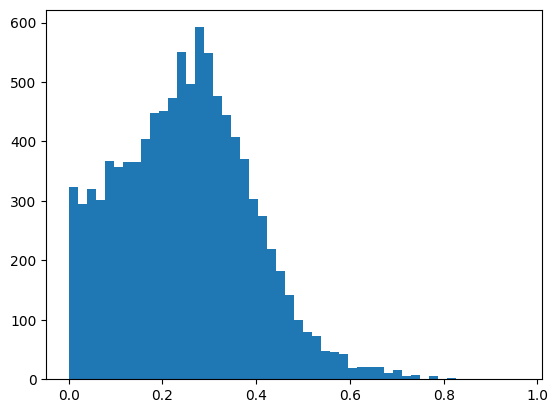

In [94]:
import matplotlib.pyplot as plt
hist_bin_size = []
for i in range(10000):
    hist_bin_size.append(decode_binary_to_weights(generate_random_solution(10, bin_str_size = 3))[0])
plt.hist(hist_bin_size, bins=50)
plt.show()

In [95]:
#stocks_df = stocks_df.set_index('ticker', 'datetime')

In [96]:
stocks_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ticker'], dtype='object')

In [111]:
sharpe_df = stocks_df.reset_index()
sharpe_df = sharpe_df.rename(columns={"index" : "time"})
sharpe_df = sharpe_df.set_index(['ticker', 'time'])
sharpe_df

Open   High    Low  Close  Adj Close     Volume
ticker   time                                                        
AALR3.SA 2022-01-03  14.96  14.96  13.51  13.58      13.58   601000.0
         2022-01-04  13.54  14.14  13.30  13.51      13.51   743300.0
         2022-01-05  13.54  13.58  12.66  12.68      12.68   359600.0
         2022-01-06  12.75  13.00  12.41  12.90      12.90   502900.0
         2022-01-07  12.86  13.56  12.45  12.85      12.85   539900.0
...                    ...    ...    ...    ...        ...        ...
ZAMP3.SA 2022-12-23   4.97   5.62   4.97   5.62       5.62   887100.0
         2022-12-26   5.50   5.86   5.43   5.48       5.48   760000.0
         2022-12-27   5.52   5.58   5.21   5.28       5.28   920700.0
         2022-12-28   5.35   5.41   5.22   5.35       5.35   421100.0
         2022-12-29   5.35   5.59   5.31   5.45       5.45  1286500.0

[119087 rows x 6 columns]

In [137]:
portfiolio = greedy_portfolio(RLC_length = 150, portfolio_length = 15)
portfiolio = [ticker[0] for ticker in portfiolio]
portfolio_weights = decode_binary_to_weights(generate_random_solution(len(portfiolio), bin_str_size = 7))

portfolio_dict = {k : v for (k, v) in zip(portfiolio, portfolio_weights)}
portfolio_dict

{'ITUB4.SA': 0.12067260138476756,
 'PRNR3.SA': 0.11671612265084075,
 'MOAR3.SA': 0.06429277942631058,
 'OPCT3.SA': 0.02967359050445104,
 'PRIO3.SA': 0.08605341246290801,
 'PLPL3.SA': 0.05341246290801187,
 'ELMD3.SA': 0.09000989119683482,
 'FESA4.SA': 0.008902077151335312,
 'MNPR3.SA': 0.10979228486646884,
 'TECN3.SA': 0.05934718100890208,
 'BPAC5.SA': 0.08605341246290801,
 'BPAC3.SA': 0.09693372898120672,
 'ENAT3.SA': 0.07418397626112759,
 'BRSR6.SA': 0.002967359050445104,
 'KEPL3.SA': 0.0009891196834817012}

In [121]:
portfolio_df = sharpe_df.loc[portfiolio]
portfolio_df

Open        High         Low       Close   
ticker   time                                                         
FESA4.SA 2022-01-03   49.049999   49.610001   47.779999   48.439999  \
         2022-01-04   48.380001   49.740002   47.330002   47.570000   
         2022-01-05   47.580002   47.650002   45.360001   45.520000   
         2022-01-06   45.619999   46.500000   44.779999   45.250000   
         2022-01-07   45.020000   47.220001   44.799999   46.880001   
...                         ...         ...         ...         ...   
BMKS3.SA 2022-12-23  300.000000  300.000000  299.989990  300.000000   
         2022-12-26  299.489990  299.500000  299.489990  299.500000   
         2022-12-27  320.000000  320.000000  281.000000  310.500000   
         2022-12-28  290.000000  310.500000  290.000000  308.000000   
         2022-12-29  310.000000  316.000000  310.000000  316.000000   

                      Adj Close    Volume  
ticker   time                              
FESA4.SA 2022-01-03   43.431656  509600.0  
         2022-01-04   42.710178  536300.0  
         2022-01-05   40.869610  358500.0  
         2022-01-06   40.627190  519300.0  
         2022-01-07   42.090672  464000.0  
...                         ...       ...  
BMKS3.SA 2022-12-23  255.548981      29.0  
         2022-12-26  255.123062       2.0  
         2022-12-27  264.493195     292.0  
         2022-12-28  262.363617      85.0  
         2022-12-29  269.178253      11.0  

[3750 rows x 6 columns]

In [164]:
len([time_index[1] for time_index in portfolio_df.index.values])

3750

In [166]:
days = len(set([time_index[1] for time_index in portfolio_df.index.values]))

250

In [173]:
def portfolio_returns_sharpe(weights, df):

    weights = portfolio_dict
    df = portfolio_df
    
    days = len(set([time_index[1] for time_index in portfolio_df.index.values]))

    df['weight'] = df.index.get_level_values('ticker').map(weights)

    # Calculate daily returns
    df['return'] = df.groupby('ticker')['Adj Close'].pct_change()

    # Calculate portfolio return
    df['portfolio_return'] = df['return'] * df['weight']

    # Calculate daily portfolio return
    daily_portfolio_return = df.groupby('time')['portfolio_return'].sum()

    # Calculate cumulative portfolio return
    cumulative_portfolio_return = (1 + daily_portfolio_return).cumprod() - 1
    

    # Calculate daily risk-free rate (e.g., use Treasury yields)
    risk_free_rate = 0.02 / days  # Assuming a 2% annual risk-free rate

    # Calculate portfolio Sharpe ratio
    daily_sharpe_ratio = (daily_portfolio_return.mean() - risk_free_rate) / daily_portfolio_return.std()

    # Calculate annualized Sharpe ratio
    annual_sharpe_ratio = daily_sharpe_ratio * (days ** 0.5)

    #print("Cumulative Portfolio Return:")
    print(cumulative_portfolio_return)

    #print("\nAnnualized Sharpe Ratio:")
    print(annual_sharpe_ratio)
    
    return cumulative_portfolio_return, annual_sharpe_ratio


In [174]:
portfolio_returns, sharpe = portfolio_returns_sharpe(portfolio_dict, portfolio_df)

time
2022-01-03    0.000000
2022-01-04   -0.000148
2022-01-05   -0.000531
2022-01-06   -0.000584
2022-01-07   -0.000264
                ...   
2022-12-23    0.002369
2022-12-26    0.002316
2022-12-27    0.002423
2022-12-28    0.002482
2022-12-29    0.002288
Name: portfolio_return, Length: 250, dtype: float64
-4.677988377767097


In [175]:
def perturbate_solution(s, n = 1):
    for i in range(n):
        pos = np.random.choice(len(s))
        
        binary_list = list(s)
        
        if binary_list[pos] == '0':
            binary_list[pos] = '1'
        else:
            binary_list[pos] = '0'
        
        s = ''.join(binary_list)
    
    return s

In [182]:
pf_test = generate_random_solution(portfolio_length=2, bin_str_size=2)
pt_test = perturbate_solution(pf_test)
print(pf_test)
print(pt_test)

0010
0000


In [185]:
RLC_length = 150
portfolio_length = 15
bin_str_size = 7

#Initial greedy solutin
portfiolio = greedy_portfolio(RLC_length, portfolio_length)

portfiolio = [ticker[0] for ticker in portfiolio]
portfolio_weights = decode_binary_to_weights(generate_random_solution(len(portfiolio), bin_str_size))

#greedy solution with random weights
portfolio_dict = {k : v for (k, v) in zip(portfiolio, portfolio_weights)}

In [ ]:
def tabu_search(max_iterations, n_neighbors, early_stop_n, tabu_list_len, s0, df):

    tabu_list, bin_list, bin_bests, score_list, best_scores, mean_scores = [], [], [], [], [], []

    portfolio_df = df.loc[[stock for stock in s0.keys()]]

    _, best_score = portfolio_returns_sharpe(s0, df)
    best_solution = s0
    iteration, best_iteration = 0, 0
    
    while (iteration <= max_iterations) and (iteration - best_iteration <= early_stop_n):
        #Neighborhood and scores
        neighborhood = generate_neighborhood(n_neighbors, s0)
        neighbors_scores = [solution_score(bin_phrase, neighbor) for neighbor in neighborhood]
        min_neighbor_score =  min(neighbors_scores)
        best_neighbor = neighborhood[neighbors_scores.index(min_neighbor_score)]
        
        if (best_neighbor not in tabu_list) or (min_neighbor_score <= best_score):
            tabu_list = update_tabu_list(tabu_list, tabu_list_len, best_neighbor)
            s0, s0_score = best_neighbor, min_neighbor_score
            bin_list.append(s0)
            score_list.append(s0_score)
            mean_scores.append(np.mean(neighbors_scores))
            if s0_score <= best_score:
                best_score = s0_score
                best_solution = s0
                best_iteration = iteration
                bin_bests.append(best_solution)
                best_scores.append(best_score)
            
        
        iteration += 1
        
    return best_solution, best_score, bin_list, score_list, bin_bests, best_scores, mean_scores


In [ ]:
tabu_search(max_iterations, n_neighbors, early_stop_n, tabu_list_len, s0 = portfolio_dict, df = sharpe_df)